# Behavioral Cloning Project Using Generators

## Read CSV File

In [2]:
import os
import csv

def read_data(csv_paths_array):
    samples = []
    for i in range(len(csv_paths_array)):
        with open(csv_paths_array[i],'r') as csv_file:
            reader = csv.reader(csv_file)
            for line in reader:
                samples.append(line)
    return samples

In [3]:
import sklearn

samples = read_data(['./recordings/k_1_lap_1/driving_log.csv',
                     './recordings/k_1_lap_2/driving_log.csv',
                     './recordings/k_1_lap_3/driving_log.csv',
                     './recordings/k_counterclock_1/driving_log.csv',
                     './recordings/charp_turns/driving_log.csv', 
                     './recordings/k_recovering/driving_log.csv',
                     './recordings/m_sharp_turns/driving_log.csv',
                     './recordings/m_3_laps_counter/driving_log.csv',
                     './recordings/m_3_laps/driving_log.csv',
                     './recordings/normal_3_laps/driving_log.csv', 
                     './recordings/1_lap_with_mouse_1/driving_log.csv',
                     './recordings/1_lap_with_mouse_2/driving_log.csv',
                     './recordings/1_lap_with_mouse_3/driving_log.csv',
                     './recordings/1_recovering_with_mouse/driving_log.csv',
                     './recordings/1_sharp_turns_with_mouse_1/driving_log.csv',
                    
                    ])
samples= sklearn.utils.shuffle(samples)

In [4]:
len(samples)

29540

## Train, Validation   Split 

In [5]:
from sklearn.model_selection import train_test_split
import sklearn

sklearn.utils.shuffle(samples)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

## Train and Validation Generators

In [6]:
import cv2
import sklearn

def generator(samples, batch_size=32, flip_center=True, side_cams=True , correction=0.5):
    num_samples = len(samples)
    while 1:
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                if flip_center:
                    flip_center_image = cv2.flip(center_image, 1)
                    flip_center_angle = -1 * center_angle
                    images.append(flip_center_image)
                    angles.append(flip_center_angle)
                if side_cams:
                    name = batch_sample[1]
                    left_image = cv2.imread(name)
                    left_angle = float(batch_sample[3])
                    images.append(left_image)
                    angles.append(left_angle + correction)
                    name = batch_sample[2]
                    right_image = cv2.imread(name)
                    right_angle = float(batch_sample[3])
                    images.append(right_image)
                    angles.append(right_angle - correction)
            #images_resized = []
            #for image in images:
            #    images_resized.append(resize(image, resize_dim))
            X_batch = np.array(images)
            y_batch = np.array(angles)
            X_batch, y_batch = sklearn.utils.shuffle(X_batch, y_batch)
            #assert len(X_batch) == batch_size, 'len(X_batch) == batch_size should be True'
            yield X_batch, y_batch


In [7]:
# Set batch size
batch_size= 8
batch_size_validation= 8

In [8]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size, flip_center=True, side_cams=True )
validation_generator = generator(validation_samples, batch_size=batch_size_validation,flip_center=False, side_cams=False )

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, ReLU
from keras.layers import Convolution2D, Cropping2D, Dropout
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

import numpy as np
import math

In [11]:
from keras.optimizers import Adam
def train_model(dropout=0.25):
    model = Sequential()
    
    # crop top and bottom
    model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))
    # normalize data
    model.add(Lambda(lambda x: x / 255 - 0.5)) #, input_shape=(160,320,3)
    #model.add(BatchNormalization())
    
    # 1. convolution layer
    model.add(Convolution2D(24, 5, padding='valid'))
    #model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Dropout(dropout))

    # 2. convolution layer
    model.add(Convolution2D(36, 5, padding='valid'))
    #model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())
    model.add(Dropout(dropout))

    # 3. convolution layer
    model.add(Convolution2D(48, 3, padding='valid'))
    #model.add(BatchNormalization())
    model.add(ReLU())
    #model.add(MaxPooling2D())
    model.add(Dropout(dropout))

    # 4. convolution layer
    model.add(Convolution2D(64, 3, padding='valid'))
    #model.add(BatchNormalization())
    model.add(ReLU())
    #model.add(MaxPooling2D())
    model.add(Dropout(dropout))
    
    # 5. convolution layer
    model.add(Convolution2D(64, 3, padding='valid'))
    #model.add(BatchNormalization())
    model.add(ReLU())
    #model.add(MaxPooling2D())
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(100))
    #model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(dropout))
    model.add(Dense(50))
    #model.add(BatchNormalization())
    model.add(ReLU())
    #model.add(Dropout(dropout))
    model.add(Dense(10))
    model.add(ReLU())
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    #model.summary()
    optimizer = Adam(lr=0.001)
    model.compile(loss='mse', optimizer=optimizer)

    history_object = model.fit(train_generator, 
                        steps_per_epoch=math.ceil(len(train_samples)/(4 * batch_size)), 
                        validation_data=validation_generator, 
                        validation_steps=math.ceil(len(validation_samples)/batch_size), 
                        epochs=3, verbose=1 ) #, use_multiprocessing=True, workers=4
  
    return model, history_object

## Train and Plot Accuracies

In [12]:
# train and save history
model, history_object= train_model()

Epoch 1/3
739/739 [==============================] - 93s 126ms/step - loss: 0.0832 - val_loss: 0.0494
Epoch 2/3
739/739 [==============================] - 93s 126ms/step - loss: 0.0711 - val_loss: 0.0590
Epoch 3/3
739/739 [==============================] - 99s 133ms/step - loss: 0.0693 - val_loss: 0.0514


In [13]:
# save model
model.save('model_with_generators_v11.h5')

dict_keys(['loss', 'val_loss'])


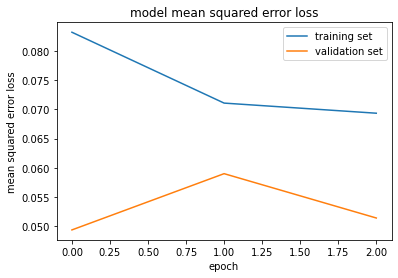

In [14]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
import matplotlib.pyplot as plt
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
from keras.applications import InceptionV3

model2 =InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,    
)

In [ ]:
model2.summary()